# <font face="Verdana" size=6 color='#6495ED'> IAD-004 APRENDIZAGEM DE MÁQUINA 1
<font face="Verdana" size=3 color='#40E0D0'> Professores Larissa Driemeier e Thiago Martins

<center><img src='https://drive.google.com/uc?export=view&id=1J3dF7v9apzpj27oOsrT8aEagtNIYwq7J' width="600"></center>

Este notebook introdutório é sobre __Máquinas de Vetores de suporte__, baseado na aula [IAD-004](https://alunoweb.net/moodle/pluginfile.php/143143/mod_resource/content/1/ML1_C05_SVM_Y2024.pdf), ano 2024.

O Notebook apresentado é uma compilação de ideias apresentadas nas seguintes fontes:

1. Livro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) de Jake VanderPlas, cuja programação em Python está disponível no [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).
2. Texto [SVM Example](http://axon.cs.byu.edu/Dan/678/miscellaneous/SVM.example.pdf), elaborado por Dan Ventura.
3. Notas de aula [CS229 Lecture Notes](http://cs229.stanford.edu/notes/cs229-notes3.pdf), elaboradas por Angrew Ng.
4. Exemplo [k-fold](https://machinelearningmastery.com/k-fold-cross-validation/), por Jason Brownlee.
5. Artigo clássico [Data classification using Support vector Machine (SVM), a simplified approach ](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.683.210&rep=rep1&type=pdf), de S. Amarappa e S. V. Sathyanarayana.

## O que é SVM?

Máquina de Vetores de Suporte, ou SVMs (do inglês, Support Vector Machine) é um método de aprendizado relativamente novo usado para classificação binária. A idéia básica é encontrar um hiperplano que separe perfeitamente os dados $d$-dimensionais em suas duas classes. No entanto, como os dados de exemplo geralmente não são separáveis linearmente, os SVMs introduzem a noção de um *espaço de recursos induzido pelo kernel* que lança os dados em um espaço dimensional mais alto, geralmente desconhecido, onde os dados são separáveis.

O SVM foi proposto por Vladimir Vapnik, em sua tese de doutorado na década de 60. As Máquinas de Vetores de Suporte foram introduzidas pela primeira vez para resolver os problemas de classificação de padrões de escrita em 1992, quando Vapnik migrou para os EUA para trabalhar na Bell Labs. Em 1992, Vapnik e colegas tiveram a ideia de aplicar o que é chamado de *Kernel Trick*, que permite usar o SVM para classificar dados linearmente não separáveis.

Os SVMs são poderosos, pois desfrutam de uma base teórica sólida e de sucesso em aplicações do mundo real. Possui uma estrutura simples e requer menos número de recursos.

Não iremos usar as ferramentas do Python, que tornam extremamente simples a aplicação do modelo. Para ilustrar as idéias básicas, iremos resolver passo a passo um problema teórico. Começaremos com um SVM linear (ou seja, um modelo que assume que os dados são linearmente separáveis) e depois expandiremos o exemplo para o caso não linear para demonstrar o papel da função de mapeamento. Finalmente, explicaremos a idéia de um kernel e como ele permite que os SVMs utilizem espaços de *features* de alta dimensão.

Importando os pacotes necessários

In [44]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC # "Support vector classifier"

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [45]:
import cvxopt.solvers

## Margem hard linear
Suponha o conjunto de dados positivos e negativos, respectivamente:
$$
x_+ = \left\{ \left(
\begin{array}{c}
3\\ 1
\end{array} \right), \left(
\begin{array}{c}
3\\ -1
\end{array} \right), \left(
\begin{array}{c}
6\\ 1
\end{array} \right),\left(
\begin{array}{c}
6\\ -1
\end{array} \right)
\right\}
$$
e
$$
x_- = \left\{ \left(
\begin{array}{c}
1\\ 0
\end{array} \right), \left(
\begin{array}{c}
0\\ 1
\end{array} \right), \left(
\begin{array}{c}
0\\ -1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 0
\end{array} \right)
\right\}
$$

Queremos usar a técnica mais simples de SVM para discriminar com precisão as duas classes. Como os dados são linearmente separáveis, podemos usar um SVM linear.

Primeiros passos:
* Plotar os dados;
* Encontrar os vetores de suporte


In [46]:
norm = mpl.colors.Normalize(-1,1)
colors = [[norm(-1.0), "teal"],
          [norm(-0.6), "darkseagreen"],
          [norm( 0.6), "steelblue"],
          [norm( 1.0), "navy"]]

mycmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [ ]:
# dados positivos
xp = np.array([3, 3, 6., 6.])
yp = np.array([1., -1., 1., -1.])

#dados negativos
xn = np.array([1., 0., 0., -1.])
yn = np.array([0., 1., -1., 0.])

#
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.xlim(-2, 7)
plt.ylim(-2, 2)
plt.show()

Um classificador discriminativo linear tentaria desenhar uma linha reta que separasse os dois conjuntos de dados e, assim, criar um modelo para classificação. Para dados bidimensionais como os nossos, essa é uma tarefa que podemos realizar manualmente. Mas imediatamente vemos um problema: há mais de uma linha divisória possível que pode discriminar perfeitamente entre as duas classes! Veja o gráfico plotado a seguir.


In [ ]:
xfit = np.linspace(-1, 6)
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.plot([1.5], [-0.5], 'x', color='crimson', markeredgewidth=2, markersize=10)

for m, b in [(2, -3), (1, -1.5), (-6, 12), (-80, 100)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-2, 7)
plt.ylim(-2, 2);


Os hiperplanos separadores apresentados são muito diferentes, porém, discriminam perfeitamente essas amostras. Dependendo da sua escolha, um novo ponto de dados (por exemplo, o marcado pelo "X" vermelho no gráfico) receberá um rótulo diferente! Evidentemente, nossa simples intuição de "traçar uma linha entre as classes" não é suficiente, e precisamos pensar um pouco mais.

E a ilustração de um novo dado em vermelho mostra que a resposta de nosso classificador dependerá do hiperplano que escolhermos.

### Máquinas de vetores de suporte: maximizando a *margem*

As máquinas de vetores de suporte oferecem uma maneira de melhorar isso.
A intuição é a seguinte: em vez de simplesmente desenhar uma linha de largura zero entre as classes, podemos desenhar em torno de cada linha uma *margem* de alguma largura, até o ponto mais próximo...

<center><img src='https://drive.google.com/uc?export=view&id=1pB4IqFcJxynCgof82ExhP7GkkpIVXYAR' width="500"></center>

Em SVM, a linha que maximiza essa margem é a que escolheremos como o modelo ideal.

In [ ]:
xfit = np.linspace(-1, 6)
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.plot([1.5], [-0.5], 'x', color='crimson', markeredgewidth=2, markersize=10)

for m, b, d in [(2, -3.5, 1.2), (1, -1.5, 0.35), (-6, 11.5, 4.6)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)
plt.xlim(-2, 7)
plt.ylim(-2, 2);

A seguir, usamos uma biblioteca Python somente para termos um *gabarito* para nosso exercício.

In [ ]:
model = SVC(kernel='linear', C=1E10)
model.fit(X.T, y)

A função `plot_SVC` definida abaixo e plota o resultado obtido pela biblioteca Pyhton sobre o gráfico com todos os vetores.




In [51]:
def plot_SVC(model, ax=None, plot_support=True):
    """Plotagem da margem máxima"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # grid para avaliar o modelo
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    # Aplica o modelo treinado no grid
    P = model.decision_function(xy).reshape(X.shape)

    print('Coeficientes do modelo w1, w2 ='+ str(model.coef_))
    print('b = '+str(model.intercept_))
    # Plota as linhas de limite de classificação e margens de decisão (níveis -1,0,1)
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Plota os vetores de suporte
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   marker='o', s=500, edgecolor='black', facecolors='crimson',
                   linewidth=1, alpha = 0.95);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plot_SVC(model)

##SVM e o problema de Lagrange

Quando falamos em  *maximizar* a margem, estamos falando de um problema de otimização, com restrições. Particularmente, nosso caso é um exemplo de programação quadrática e, devemos, portanto, minimizar uma função quadrática sujeita a restrições lineares,

\begin{aligned}&{\underset {\boldsymbol{\omega},b}{\operatorname {minimizar} }}&&L(\boldsymbol{\omega},b)=\frac{1}{2}||\boldsymbol{\omega}||^2\\&\operatorname {sujeito\;a} &&y^{(i)}\left(\boldsymbol{\omega}^Tx^{(i)}+b\right)\ge 1\end{aligned}

Essa otimização é chamada de problema primal e é garantido que tenha um mínimo global. Podemos resolver  introduzindo multiplicadores de Lagrange ($\alpha_i$) e convertendo-a para o problema dual:
\begin{equation}
{\underset {\boldsymbol{\alpha}}{\operatorname {max} }}
\text{  } {\underset {\boldsymbol{\omega},b}{\operatorname {min} }}
\text{  }L(\boldsymbol{\omega},b,\boldsymbol{\alpha})
\end{equation}
onde,
\begin{equation}
L(\boldsymbol{\omega},b,\boldsymbol{\alpha})=\frac{1}{2}||\boldsymbol{\omega}||^2-\sum_{i=1}^m{\alpha_i \left[y^{(i)}\left(\boldsymbol{\omega}^T\boldsymbol{x}^{(i)}+b\right)- 1\right]}
\end{equation}

Essa é a função Lagrangiana do SVM, que é diferenciável em relação a $\boldsymbol{\omega}$ e $b$,

\begin{cases} \frac{\partial{L}}{\partial \boldsymbol{\omega}} = 0 \Longrightarrow \boldsymbol{\omega}=\sum_{i=1}^m{\alpha_iy^{(i)}\boldsymbol{x}^{(i)}} \\ \frac{\partial{L}}{\partial b} = 0 \Longrightarrow \boldsymbol{\omega}=\sum_{i=1}^m{\alpha_iy^{(i)}=0}\end{cases}

Ao substituir os resultados acima na função Lagrangiana, obteremos o problema dual do SVM:

\begin{aligned}&{\underset {\boldsymbol{\alpha}}{\operatorname {maximizar} }}\quad L(\boldsymbol{\alpha})=\sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i=1}^m{\sum_{j=1}^m {\alpha_i \alpha_j y^{(i)}y^{(j)}\boldsymbol{x}^{(i)T}\boldsymbol{x}^{(j)}}}\\&\operatorname {sujeito\;a} \quad\alpha_i \ge 0,\qquad i=1,\cdots,m\end{aligned}
com a seguinte restrição em $\alpha$,

\begin{equation}
\sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{equation}

O problema acima pode ser escrito na forma quadrática convexa de um problema clássico de otimização
\begin{array}{cl}{\underset{x}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T} \mathbf{P} \boldsymbol{\alpha}+\mathbf{q}^{T} \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {\mathbf{G} \boldsymbol{\alpha} \leq \mathbf{h}} \\ {} & {\mathbf{A} \boldsymbol{\alpha}=\mathbf{b}}\end{array}

Veja que podemos reescrever cpode ser reescrito como:
\begin{array}{cl}{\underset{\alpha}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T}\left(\mathbf{y y}^{T} \mathbf{K}\right) \boldsymbol{\alpha}-\boldsymbol{1}^T \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {-\boldsymbol{\alpha} \leq \mathbf{0}} \\ {} & {\mathbf{y} \cdot \boldsymbol{\alpha}=0}\end{array}
onde:
$$
\boldsymbol{\alpha}=\left(\alpha_{1}, \ldots, \alpha_{m}\right)^{T},\mathbf{y}=\left(y_{1}, \cdots, y_{m}\right)^{T}  \text { e }  \boldsymbol{1}=\left(1, \ldots,1 \right)^{T}
$$
e
$$
K\left(\mathbf{x}_{1}, \ldots, \mathbf{x}_{m}\right)=\left(\begin{array}{cccc}{\mathbf{x}_{1} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{1} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{1} \cdot \mathbf{x}_{m}} \\ {\mathbf{x}_{2} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{2} \cdot \mathbf{x}_{2}} & {\ldots} & {\mathbf{x}_{2} \cdot \mathbf{x}_{m}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\mathbf{x}_{m} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{m} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{m} \cdot \mathbf{x}_{m}}\end{array}\right)
$$

O problema de Lagrange retorna os valores de $\alpha_i$ diferentes de zero para os vetores de suporte, que são os vetores que atingem a menor distância da margem. São pontos de dados de treinamento que estão mais próximos do hiperplano e influenciam a posição e a orientação do hiperplano. Usando esses vetores de suporte, maximizamos a margem do classificador.

Os vetores de suporte são os exemplos mais difíceis de classificar. São os elementos críticos do conjunto de treinamento.

Somente um subconjunto muito pequeno de amostras de treinamento (vetores de suporte) pode especificar completamente a função de decisão. Os pontos interiores não contribuem em nada para solução!


O modelo de classificação é obtido comm $\boldsymbol{\omega}$ e $b$. O vetor $\boldsymbol{\omega}$ é simples de obter, porque a fórmula para$\boldsymbol{\omega}$ é uma das restrições que usamos para montar nosso problema quadrático,
\begin{equation}
\boldsymbol{\omega}=\sum_{i=1}^{n_{sv}}{\alpha_iy^{(i)}\boldsymbol{x}^{(i)}}
\end{equation}
onde $n_{sv}$ é o número de vetores de suporte.

Para encontrar o valor de $b$ usamos a equação abaixo para qualquer vetor de suporte $\boldsymbol{x}^{(i)}$:
\begin{equation}
y^{(i)}\left(\boldsymbol{\omega}^T\boldsymbol{x}^{(i)}+b\right)=1
\end{equation}

A classificação de um novo vetor de características $\mathbf{x}$ é dado por:
$$
h\left(\mathbf{x}^{(i)}\right)=\operatorname{sign}\left(\mathbf{w} \cdot \mathbf{x}^{(i)}+b\right)
$$

Uma chave para o sucesso desse classificador é que, para o ajuste, apenas a posição dos vetores de suporte é importante; quaisquer pontos mais afastados da margem, desde que estejam do lado correto da classificação,  não modificam o ajuste! Tecnicamente, isso ocorre porque esses pontos não contribuem para a função de perda usada para ajustar o modelo, portanto, sua posição e número não importam, desde que não ultrapassem a margem.


### Um parênteses sobre o multiplicador de Lagrange

Imagine que você deseja minimizar alguma função de duas variáveis, digamos $f(x, y) = x^2 + y^2$. Claramente, isso tem um mínimo em $(x, y) = (0,0)$.

Mas e se exigirmos que $x + y = 1$? Onde está o mínimo que obedece a essa condição?

A maneira força bruta é isolar $y = 1 - x$, então

$$
f(x, y) = f(x, y(x)) = x^2 + (1 - x)^2 = 2x^2 + 1 - 2x
$$

e, portanto, o mínimo, diferenciando:

$$
f'(x) = 4x - 2 = 0
$$

é em $x = \frac{1}{2}$, ou seja, em $(x, y) = \left(\frac{1}{2}, \frac{1}{2}\right)$.

Também podemos escrever a condição como

$$
x + y - 1 = 0 = \lambda (x + y - 1)
$$

Multiplicamos por $\lambda$, o que é permitido, pois igualamos a zero de qualquer maneira. Vamos adicionar zero, ou seja, esse tipo especial de zero, a $f(x, y)$:

$$
f(x, y) = x^2 + y^2 + \lambda (x + y - 1)
$$

Agora vamos tentar minimizar novamente, mas agora considere $x$ e $y$ independentes:

$$
\frac{\partial f}{\partial x} = 2x + \lambda = 0
$$

$$
\frac{\partial f}{\partial y} = 2y + \lambda = 0
$$

Eliminando $\lambda$ obtemos $x = y$.

Sabendo que $x = y$ nos dá imediatamente $(x, y) = \left(\frac{1}{2}, \frac{1}{2}\right)$ a partir de $x + y = 1$. Então, adicionar esse $\lambda$ nos permitiu pular a etapa de substituição. Podemos também resolver para $\lambda$ se quisermos: $\lambda = -1$.

$\lambda$ é conhecido como um multiplicador de Lagrange. É simplesmente um truque inteligente. Também não é muito difícil provar que funciona, mas vou pular isso aqui. Em conclusão: um multiplicador de Lagrange é uma variável que introduzimos para encontrar um extremo.


In [ ]:
# Definindo a função f(x, y) = x^2 + y^2
def f(x, y):
    return x**2 + y**2

# Criando uma grade de valores de x e y
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Desenhando as curvas de nível
plt.scatter(0, 0,  s=20, marker='o', cmap='viridis')
plt.contour(X, Y, Z, levels=np.linspace(-1, 25, 50), cmap='viridis')
plt.colorbar(label='Nível de f(x, y)')

# Adicionando títulos e rótulos
plt.title('Curvas de Nível de $f(x, y) = x^2 + y^2$')
plt.xlabel('x1')
plt.ylabel('x2')

# Mostrando o gráfico
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo a função f(x, y) = x^2 + y^2
def f(x, y):
    return x**2 + y**2

# Criando uma grade de valores de x e y
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Desenhando as curvas de nível
#plt.scatter(1/2, 1/2,  s=20, marker='o', cmap='viridis')
plt.contour(X, Y, Z, levels=np.linspace(-1, 25, 51), cmap='viridis')
plt.colorbar(label='Nível de f(x, y)')

# Adicionando a linha x + y = 1
x_line = np.linspace(-5, 5, 400)
y_line = 1 - x_line
plt.plot(x_line, y_line, 'r--', label='$x + y = 1$')

# Adicionando títulos e rótulos
plt.title('Curvas de Nível de $f(x, y) = x^2 + y^2$')
plt.xlabel('x')
plt.ylabel('y')

# Adicionando uma legenda
plt.legend()

# Mostrando o gráfico
plt.grid(True)
plt.show()


In [ ]:
max_x = 2
min_x = -2
n_x = 300
max_y = 2
min_y = -2
n_y = 300
xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_x), np.linspace(min_y, max_y, n_y))
f_xy = xx**2+yy**2
g_xy = xx +yy - 1

th = 0.05
ax = plt.figure().add_subplot(projection='3d')
cc = np.repeat(np.where(np.abs(g_xy)<th, 0.0,1.0)[:,:,np.newaxis],3,axis=2)
ax.plot_surface(xx, yy, f_xy,cmap = 'viridis',  rcount = 400, ccount=200, alpha = 0.9, lw=0.);
ax.scatter(0,0,0, color='black', s=50);

In [ ]:
max_x = 2
min_x = -2
n_x = 300
max_y = 2
min_y = -2
n_y = 300
xx, yy = np.meshgrid(np.linspace(min_x, max_x, n_x), np.linspace(min_y, max_y, n_y))
f_xy = xx**2+yy**2
g_xy = xx +yy - 1

th = 0.05
ax = plt.figure().add_subplot(projection='3d')
cc = np.repeat(np.where(np.abs(g_xy)<th, 0.0,1.0)[:,:,np.newaxis],3,axis=2)
ax.plot_surface(xx, yy, f_xy,facecolors=cc,  rcount = 400, ccount=200, alpha = 0.9, lw=0.);
ax.scatter(1/2, 1/2, 1/2, color='black', s=50);

### Solução sem resolver o problema de otimização

Teoricamente, tem-se a definição de,
$$
\omega^T x^{(j)}+b = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} \langle x^{(i)},x^{(j)}\rangle + b = y^{(i)}
$$
onde $\langle x^{(i)},x^{(j)}\rangle$ é o produto interno entre os vetores $x^{(i)}$ e $x^{(j)}$ e $n_{sv}$, conforme já mencionado, é o número de vetores de suporte.

Para nosso exemplo, teremos,
$$
\alpha_1 y^{(1)} x^{(1)}\cdot x^{(1)} + \alpha_2 y^{(2)} x^{(2)}\cdot x^{(1)} + \alpha_3 y^{(3)} x^{(3)}\cdot x^{(1)} +b = y^{(1)} \\
\alpha_1 y^{(1)} x^{(1)}\cdot x^{(2)} + \alpha_2 y^{(2)} x^{(2)}\cdot x^{(2)} + \alpha_3 y^{(3)} x^{(3)}\cdot x^{(2)} +b = y^{(2)} \\ \tag{1}
\alpha_1 y^{(1)} x^{(1)}\cdot x^{(3)} + \alpha_2 y^{(2)} x^{(2)}\cdot x^{(3)} + \alpha_3 y^{(3)} x^{(3)}\cdot x^{(3)} +b = y^{(3)}
$$

Por inspeção, verifica-se que os vetores de suporte são 3: $(1,0)$ para $y=-1$; $(3,1)$, para $y=+1$; e $(3,-1)$, para $y=+1$. Dessa forma, pode-se escrever os vetores de suporte $sv_i, i=1,...,3$ como,
$$
sv_1 = \left(
\begin{array}{c}
 1 \\0
\end{array} \right)
 \qquad
sv_2 = \left(
\begin{array}{c}
3 \\ 1
\end{array} \right)
 \qquad
sv_3 = \left(
\begin{array}{c}
3 \\ -1
\end{array} \right)
$$

Substituindo-se os valores nas equações $(1)$, tem-se:
 $$
-\alpha_1 x^{(1)}\cdot x^{(1)} + \alpha_2 x^{(2)}\cdot x^{(1)} + \alpha_3  x^{(3)}\cdot x^{(1)} + b = -1 \\
-\alpha_1 x^{(1)}\cdot x^{(2)} + \alpha_2 x^{(2)}\cdot x^{(2)} + \alpha_3  x^{(3)}\cdot x^{(2)} + b = +1 \\ \tag{2}
-\alpha_1 x^{(1)}\cdot x^{(3)} + \alpha_2 x^{(2)}\cdot x^{(3)} + \alpha_3  x^{(3)}\cdot x^{(3)} + b = +1
$$

Precisamos de uma equação extra, pois temos 4 incógnitas e 3 equações. Porém, devemos lembrar que:
$$
\sum_{i=1}^m \alpha_i y^{(i)} = -\alpha_1  + \alpha_2 + \alpha_3 = 0
$$

Dado que $\langle x^{(1)},x^{(1)}\rangle=1$, $\langle x^{(2)},x^{(2)}\rangle=10$, $\langle x^{(3)},x^{(3)}\rangle=10$, $\langle x^{(1)},x^{(2)}\rangle=3$, $\langle x^{(2)},x^{(3)}\rangle=8$ e $\langle x^{(1)},x^{(3)}\rangle=3$, o problema resume-se a:
 $$
-1\alpha_1 + 3\alpha_2 + 3\alpha_3 +b = -1 \\
-3\alpha_1 + 10\alpha_2 + 8\alpha_3 +b = +1 \\ \tag{3}
-3\alpha_1  + 8\alpha_2  + 10\alpha_3 +b  = +1 \\
-\alpha_1  + \alpha_2 + \alpha_3 + 0b = 0
$$

Encontre os valores de $\alpha$ e $b$.

Veja que os valores de $\alpha$ encontrados seguem as restrições da otimização dual de Lagrange,
$$
\alpha_i \geq 0, i=1,...,m
$$
e
$$
\sum_{i=1}^m \alpha_i y^{(i)}=0
$$




Encontre os valores de $\omega$ e, juntamente $b$, e compare com o resultado da função SVM. Lembre-se que o resultado da função foi
```
Coeficientes do modelo w1, w2 =[[ 1.00048166e+00 -1.66533454e-16]]
b = [-2.00112388]
```


Lembre-se que:
$$
\omega = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} x^{(i)}
$$
e, para um vetor de suporte qualquer $x^{(SV)}$ qualquer,
$$
b = y^{(SV)} \left( 1- \omega^Tx^{(SV)}\right)
$$
que já foi encontrado juntamente com $\alpha$.

In [ ]:
#sua resposta

In [ ]:
#@title Gabarito
sv = np.array([[ 1., 0.],[ 3., 1.],[ 3., -1.]])
y = np.array([-1, 1, 1, 0])
A = np.zeros([4, 4])
for i in range(0,3):
  for j in range(0,3):
    A[i][j] = y[j]*np.dot(sv[i,:],sv[j,:])
  A[i][3]=1
A[3,:] = [-1, 1, 1, 0]
print(A)
alphas = np.linalg.solve(A,y)
print('alpha 1 = {:4.2f}, alpha 2 = {:4.2f}, alpha 3 = {:4.2f}'.format(alphas[0], alphas[1], alphas[2]))
print('b = {:4.2f}'.format(alphas[3]))

In [ ]:
w=np.zeros([1,2])
for i in range (0,3):
  w += alphas[i]*y[i]*sv[i,:]
b = 1.0-y[1]*np.dot(w,sv[1,:])
print('w 1 = {:4.2f}, w 2 = {:4.2f}'.format(w[0][0], w[0][1]))
print('b = {:4.2f}'.format(b[0]))

### Solução via otimização

Lembrando que problema dual do SVM:

\begin{aligned}&{\underset {\boldsymbol{\alpha}}{\operatorname {maximizar} }}\quad L(\boldsymbol{\alpha})=\sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i=1}^m{\sum_{j=1}^m {\alpha_i \alpha_j y^{(i)}y^{(j)}\boldsymbol{x}^{(i)T}\boldsymbol{x}^{(j)}}}\\&\operatorname {sujeito\;a} \quad\alpha_i \ge 0,\qquad i=1,\cdots,m\end{aligned}
com a seguinte restrição em $\alpha$,

\begin{equation}
\sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{equation}

O problema pode ser escrito na forma quadrática convexa de um problema clássico de otimização
\begin{array}{cl}{\underset{x}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T} \mathbf{P} \boldsymbol{\alpha}+\mathbf{q}^{T} \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {\mathbf{G} \boldsymbol{\alpha} \leq \mathbf{h}} \\ {} & {\mathbf{A} \boldsymbol{\alpha}=\mathbf{b}}\end{array}

Veja que podemos reescrever cpode ser reescrito como:
\begin{array}{cl}{\underset{\alpha}{\operatorname{minimize}}} & {\frac{1}{2} \boldsymbol{\alpha}^{T}\left(\mathbf{y y}^{T} \mathbf{K}\right) \boldsymbol{\alpha}-\boldsymbol{1}^T \boldsymbol{\alpha}} \\ {\text { sujeito a }} & {-\boldsymbol{\alpha} \leq \mathbf{0}} \\ {} & {\mathbf{y} \cdot \boldsymbol{\alpha}=0}\end{array}
onde:
$$
\boldsymbol{\alpha}=\left(\alpha_{1}, \ldots, \alpha_{m}\right)^{T},\mathbf{y}=\left(y_{1}, \cdots, y_{m}\right)^{T}  \text { e }  \boldsymbol{1}=\left(1, \ldots,1 \right)^{T}
$$
e
$$
K\left(\mathbf{x}_{1}, \ldots, \mathbf{x}_{m}\right)=\left(\begin{array}{cccc}{\mathbf{x}_{1} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{1} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{1} \cdot \mathbf{x}_{m}} \\ {\mathbf{x}_{2} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{2} \cdot \mathbf{x}_{2}} & {\ldots} & {\mathbf{x}_{2} \cdot \mathbf{x}_{m}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {\mathbf{x}_{m} \cdot \mathbf{x}_{1}} & {\mathbf{x}_{m} \cdot \mathbf{x}_{2}} & {\dots} & {\mathbf{x}_{m} \cdot \mathbf{x}_{m}}\end{array}\right)
$$

In [ ]:
# dados positivos
xp = np.array([3, 3, 6., 6.])
yp = np.array([1., -1., 1., -1.])

#dados negativos
xn = np.array([1., 0., 0., -1.])
yn = np.array([0., 1., -1., 0.])

#
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]

In [ ]:
def get_training_examples():
    X1 = np.array([[3.,1.], [3.,-1.], [6.,1.], [6.,-1.]])
    y1 = np.ones(len(X1))
    X2 = np.array([[1.,0], [0.,1.], [0,-1.], [-1.,0]])
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def get_dataset(get_examples):
    X1, y1, X2, y2 = get_examples()
    X, y = get_dataset_for(X1, y1, X2, y2)
    return X, y

def get_dataset_for(X1, y1, X2, y2):
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    return X, y

In [ ]:
X, y = get_dataset(get_training_examples)
m = X.shape[0]

# A matriz de todos os produtos internos possíveis de X.
K = np.array([np.dot(X[i], X[j])
              for i in range(m)
              for j in range(m)]).reshape((m, m))
P = cvxopt.matrix(np.outer(y, y) * K)
q = cvxopt.matrix(-1 * np.ones(m))
print('As matrizes e vetores do modelo de otimização quadrático \n utilizado: K, P e q, respectivamente:\n')
print(K,'\n\n',P,'\n',q)

In [ ]:
# let alpha be 1 for all obervations
# Equality constraints
A = cvxopt.matrix(y, (1, m)) # create 1*m matrix of y
b = cvxopt.matrix(0.0)
print('As matrizes e vetores do modelo de otimização quadrático \n utilizado: A e alpha, respectivamente:\n')
print(A,'\n\n',b)

In [ ]:
# Inequality constraints
G = cvxopt.matrix(np.diag(-1 * np.ones(m)))
h = cvxopt.matrix(np.zeros(m))
print('As matrizes e vetores do modelo de otimização quadrático \n utilizado: G e h, respectivamente:\n')
print(G,'\n\n',h)

In [ ]:
# Solve the problem
solution = cvxopt.solvers.qp(P, q, G, h, A, b) # return # dictionary which contains iterators

Veja os valores de alpha. O resto da solução você já conhece...

In [ ]:
print(solution['x'])

## Dados não separáveis linearmente


Dados não separáveis podem ter duas origens, como ilustrado na figura abaixo.

![Dados não separáveis](https://drive.google.com/uc?export=view&id=1zz8wZElg3D02I3bDsr4PGZeHYMPz1yt5)

### Margem soft
As margens *hard* resultarão na adaptação de um modelo que permita apenas erro zero, isto é, *nenhum* dado de treinamento deve violar a margem. Às vezes, pode ser útil permitir erros no conjunto de treinamento, pois pode produzir um modelo mais generalizável quando aplicado a novos conjuntos de dados. Forçar margens rígidas pode resultar em um modelo com desempenho perfeito no conjunto de treinamento, mas possivelmente com overfit/menos generalizável quando aplicado a um novo conjunto de dados.

Dessa maneira, podemos introduzir a ideia de *margem soft*, que resulta na introdução de um hiperparâmero $C$. A permissão margem mais “soft” (isto é, uma configuração de baixo custo) permite que erros sejam cometidos ao ajustar o modelo aos ddos de treinamento.

### Kernel

Quando o conjunto de dados é não linearmente separável no plano $\mathbf{x}$ existem duas etapas principais para a generalização não linear do SVM. A primeira etapa envolve a transformação dos dados originais de treinamento (entrada) em dados de dimensão superior usando um mapeamento não linear $\phi(\mathbf{x})=\mathbf{z}$. Uma vez que os dados são transformados na nova dimensão superior, o segundo passo envolve encontrar um hiperplano de separação linear no novo espaço. O hiperplano marginal máximo encontrado no novo espaço corresponde a uma hipersuperfície de separação não linear no espaço original.

Obviamente, para conjunto de dados reais, você tem os dois aspectos, uma combinação desses dois, e terá que combinar kernels com margem soft na maioria dos casos.


## Margem hard não linear

O problema de margem não linear pode ser contornado com o mapeamento dos dados de entrada do espaço 𝒳 para um espaço 𝒵 de dimensão $\tilde{n}$. Similar à regressão polinomial, deve-se lembrar que $\boldsymbol{x}^{(i)}$ é um conjunto de dados de entrada e, portanto, uma constante. O que realmente afeta a derivação do gradiente são os pesos e, portanto, é a linearidade em $\omega$ que permite a derivação.

Como discutido em aula, isso abre uma fantástica possibilidade, porque pode-se manipular os dados de entrada e combinar da maneira que convir! E mais, com o *truque de Kernel*, essa dimensão $\tilde{n}$ pode ser infinita.





### Exemplo
Suponha um novo conjunto de dados positivos e negativos, respectivamente:
$$
x_+ = \left\{ \left(
\begin{array}{c}
2\\ 2
\end{array} \right), \left(
\begin{array}{c}
2\\ -2
\end{array} \right), \left(
\begin{array}{c}
-2\\ -2
\end{array} \right),\left(
\begin{array}{c}
-2\\ 2
\end{array} \right)
\right\}
$$
e
$$
x_- = \left\{ \left(
\begin{array}{c}
1\\ 1
\end{array} \right), \left(
\begin{array}{c}
1\\ -1
\end{array} \right), \left(
\begin{array}{c}
-1\\ -1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 1
\end{array} \right)
\right\}
$$


In [ ]:
xp = np.array([2., 2., -2., -2.])
yp = np.array([2., -2., -2., 2.])
xn = np.array([1., 1., -1., -1.])
yn = np.array([1., -1., -1., 1.])
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
print(X)

Nosso objetivo de descobrir um hiperplano separador que discrimine com precisão as duas classes se tornou mais árduo. Obviamente, esse hiperplano não existe no espaço das variáveis de entrada 𝒳. Portanto, devemos usar um SVM não linear. Em outras palavras, usar uma função $\phi$ que mapeia o espaço não linear de entrada para algum espaço 𝒵 de características combinadas.

Supõe-se

$$
z=\phi \left( x_1,x_2 \right)= \left\{
\begin{array}{c}
\left(4-x_2+|x_1-x_2|, 4-x_1+|x_1-x_2|\right)  & \text{se  }\sqrt{x_1^2+x_2^2}>2\\
\left(x_1,x_2\right) & c.c.
\end{array}\right.
$$

Dessa forma, os vetores transformados $z_+$ e $z_-$ são dados por, respectivamente,
$$
z_+ = \left\{ \left(
\begin{array}{c}
2\\ 2
\end{array} \right), \left(
\begin{array}{c}
10\\ 6
\end{array} \right), \left(
\begin{array}{c}
6\\ 6
\end{array} \right),\left(
\begin{array}{c}
6\\ 10
\end{array} \right)
\right\}
$$
e
$$
z_- = \left\{ \left(
\begin{array}{c}
1\\ 1
\end{array} \right), \left(
\begin{array}{c}
1\\ -1
\end{array} \right), \left(
\begin{array}{c}
-1\\ -1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 1
\end{array} \right)
\right\}
$$

In [ ]:
Z = np.zeros([2,8])
y = [1, 1, 1, 1, -1, -1, -1, -1]
for i in range(0,8):
  if np.sqrt(X[0][i]**2+X[1][i]**2)>2.:
    print(i,X[0][i],X[1][i],abs(X[0][i]-X[1][i]))
    Z[0][i] = 4. - X[1][i] + abs(X[0][i]-X[1][i])
    Z[1][i] = 4. - X[0][i] + abs(X[0][i]-X[1][i])
  else:
    Z[0][i] = X[0][i]
    Z[1][i] = X[1][i]
print(Z)

In [ ]:
model = SVC(kernel='linear', C=1E10)
model.fit(Z.T, y)
plt.scatter(Z[0,:], Z[1,:], c=y, s=100, cmap=mycmap)
plot_SVC(model)

Uma vez que os dados de entrada foram mapeados para a dimensão 𝒵, o problema é similar ao resolvido anteriormente,
$$
\tilde\omega^T z^{(j)}+\tilde{b} = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} \langle z^{(i)},z^{(j)}\rangle + \tilde{b} = y^{(i)}
$$
onde $\langle z^{(i)},z^{(j)}\rangle$ é o produto interno entre os vetores $z^{(i)}$ e $z^{(j)}$ e $n_{sv}$ é o número de vetores de suporte. O símbolo $\tilde{ }$ serve apenas para alertar que estamos no espaço 𝒵.

Para nosso exemplo, teremos,
$$
\alpha_1 y^{(1)} z^{(1)}\cdot z^{(1)} + \alpha_2 y^{(2)} z^{(2)}\cdot z^{(1)} + \alpha_3 y^{(3)} z^{(3)}\cdot z^{(1)} + \tilde{b} = y^{(1)} \\
\alpha_1 y^{(1)} z^{(1)}\cdot z^{(2)} + \alpha_2 y^{(2)} z^{(2)}\cdot z^{(2)} + \alpha_3 y^{(3)} z^{(3)}\cdot z^{(2)} + \tilde{b} = y^{(2)} \\ \tag{1}
\alpha_1 y^{(1)} z^{(1)}\cdot z^{(3)} + \alpha_2 y^{(2)} z^{(2)}\cdot z^{(3)} + \alpha_3 y^{(3)} z^{(3)}\cdot z^{(3)} + \tilde{b} = y^{(3)}
$$

Por inspeção, verifica-se que os vetores de suporte são 2: $(1,1)$ para $y=-1$ e $(2,2)$, para $y=+1$. Dessa forma, pode-se escrever os vetores de suporte $sv_i, i=1,2$ como,
$$
sv_1 = \left(
\begin{array}{c}
 1 \\1
\end{array} \right)
 \qquad
sv_2 = \left(
\begin{array}{c}
2\\ 2
\end{array} \right)
$$

Substituindo-se os valores nas equações $(1)$, e adicionando a restrição de que $\sum_iy^{(i)}\alpha_i=0$ tem-se:
 $$ \begin{array}{r c}
  - \alpha_1 z^{(1)}\cdot z^{(1)} + \alpha_2 z^{(2)}\cdot z^{(1)} + \tilde{b} &= -1 \\
-\alpha_1 z^{(1)}\cdot z^{(2)} + \alpha_2 z^{(2)}\cdot z^{(2)} + \tilde{b} &= +1 \\
 -\alpha_1  + \alpha_2  &= 0
 \end{array}
$$

Dado que $\langle z^{(1)},z^{(1)}\rangle=2$, $\langle z^{(2)},z^{(2)}\rangle=8$ e $\langle z^{(1)},z^{(2)}\rangle=4$, o problema resume-se a:
 $$
-2\alpha_1 + 4\alpha_2 + \tilde{b} = -1 \\
-4\alpha_1 + 8\alpha_2 + \tilde{b} = +1 \\ \tag{2}
-\alpha_1  + \alpha_2  + 0\tilde{b} = 0
$$

Encontre os valores de $\alpha$ e depois de $\tilde{b}$ e $\tilde{\omega}$. Lembre-se que:
$$
\tilde\omega = \sum_{i=1}^{n_{sv}} \alpha_i y^{(i)} z^{(i)}
$$

In [ ]:
# Sua resposta

In [ ]:
#@title Gabarito
sv = np.array([[ 1., 1.],[ 2., 2.]])
y_sv = np.array([-1, 1, 0])
A = np.zeros([3,3])
for i in range(0,2):
  for j in range(0,2):
    A[i][j] = y_sv[j]*np.dot(sv[i,:],sv[j,:])
  A[i][2]=1
A[2,:] = [-1, 1, 0]
print(A)
print(Z)
alphas = np.linalg.solve(A,y_sv)
print('alpha 1 = {:4.2f}, alpha 2 = {:4.2f}'.format(alphas[0], alphas[1]))
print('b = {:4.2f}'.format(alphas[2]))
w=np.zeros([1,2])
for i in range (0,2):
  w += alphas[i]*y_sv[i]*sv[i,:]
w=np.array(w)
print('w 1 = {:4.2f}, w 2 = {:4.2f}'.format(w[0][0], w[0][1]))

[[-2.  4.  1.]
 [-4.  8.  1.]
 [-1.  1.  0.]]
[[ 2. 10.  6.  6.  1.  1. -1. -1.]
 [ 2.  6.  6. 10.  1. -1. -1.  1.]]
alpha 1 = 1.00, alpha 2 = 1.00
b = -3.00
w 1 = 1.00, w 2 = 1.00


In [ ]:
xlim = [-3., 5.]
ylim = [-3., 5.]
# Grid para avaliação do modelo
h = np.linspace(xlim[0], xlim[1], 300)
v = np.linspace(ylim[0], ylim[1], 300)
V,H = np.meshgrid(v, h)
xy = np.vstack([H.ravel(), V.ravel()])
dim = xy.shape[1]
P=np.zeros([dim])

z_t=np.zeros([2])
for i in range(xy.shape[1]):
  if np.sqrt(xy[0][i]**2+xy[1][i]**2)>2.:
    z_t[0] = 4. - xy[1][i] + abs(xy[0][i]-xy[1][i])
    z_t[1] = 4. - xy[0][i] + abs(xy[0][i]-xy[1][i])
  else:
    z_t[0] = xy[0][i]
    z_t[1] = xy[1][i]
  P[i] = np.sign(w[0][0]*z_t[0]+w[0][1]*z_t[1]+alphas[2])
plt.scatter(xy[0,:],xy[1,:],c=P,alpha=0.5,cmap = 'Pastel2')
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)

Olhando para as respostas no espaço de entrada, podemos ficar tentados a pensar que essa não é uma classificação razoável; no entanto, é o que diz o nosso modelo, e nosso modelo é consistente com todos os dados de treinamento.

Como sempre, não há garantias sobre a precisão da generalização e, se não estamos felizes com nossa generalização, o culpado mais provável é nossa escolha de mapeamento.


### O truque do kernel

Nossa definição de $\phi$ do exemplo anterior preservou o número de dimensões. Em outras palavras, nossos espaços de entrada 𝒳 e de mapeamento 𝒵 são do mesmo tamanho.

No entanto, geralmente é o caso de que, para separar efetivamente os dados, precisamos usar um espaço de com dimensão (às vezes muito) maior que o nosso espaço de entrada.

O *truque* é que, dados dois vetores $x^{(i)}$ e $x^{(j)}$ no espaço 𝒳, pode-se provar que não há necessidade de descriminar cada vetor $z^{(i)}$ e $z^{(j)}$ da transformação $x^{(i)} \rightarrow z^{(i)}$ e $x^{(j)} \rightarrow z^{(j)}$. I.é, a dimensionalidade de 𝒵 não aparece explicitamente na expressão, mas temos que realizar o produto interno $z^{(i)} \cdot z^{(j)}$ no espaço 𝒵. Em outras palavras, precisamos de um número, um valor. Com esse valor, o produto interno, elabora-se todo problema de vetores de suporte no espaço 𝒵, que nunca foi visitado ou conhecido e retorna-se com vetores de suporte que vivem em seu espaço 𝒵, calcula-se o desempenho baseado no número de vetores de suporte. Pode-se dizer que foi usado um espaço realmente muito sofisticado!!!!

Se alguém perguntar que espaço é esse, diga que a existência dele é suficiente!

 ![](https://drive.google.com/uc?export=view&id=1DBXMAZDTDgel8KdFqWs7ZqDLh15Iriw9)

Importante ressaltar que, nesse caso, os vetores de suporte estão no espaço 𝒵. Porque estamos trabalhando no espaço 𝒵, o hiperplano está lá, a margem está lá, e a margem irá tocar alguns pontos, os vetores de suporte. E você pode identificá-los, no espaço 𝒵.

Outro ponto importante é que existem regras para existência de kernels, ié, você não pode inventar um valor de sua cabeça. Existe uma transformação $\phi(x)=z$, 𝜙:𝒳→𝒵, que é aplicada aos vetores $x$ e $x'$ transformando-os, respectivamente, em $z$ e $z'$ e o kernel é exatamente o produto interno desses vetores $z$ e $z'$.

Linear | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Expressão: $K(x^{(i)},x^{(j)})$ &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; | Parâmetros
--- | :----------------: | :---:
Linear | $x^{(i)}\cdot x^{(j)}$ |
Polinomial | $\left(x^{(i)}\cdot x^{(j)}+1\right)^d$ | $d$
RBF |$\exp\left(-\gamma||x^{(i)}- x^{(j)}||^2\right)$ | $\gamma>0$
Hiperbólico | $\tanh\left(k(^{(i)}\cdot x^{(j)}+c\right)$ | $k,c$

RBF (do inglês, Radial Basis Funtion) é o kernel mais usado nas classificações SVM.





### Exemplo Kernel

Considere os mesmos dados do exemplo anterior.


In [ ]:
xp = np.array([2., 2., -2., -2.])
yp = np.array([2., -2., -2., 2.])
xn = np.array([1., 1., -1., -1.])
yn = np.array([1., -1., -1., 1.])
a= np.array([xp ,yp])
b= np.array([xn,yn])
X = np.concatenate((a, b), axis=1)
y = [1, 1, 1, 1, -1, -1, -1, -1]
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
print(X)

Vamos agora considerar uma função de mapeamento alternativa. Supõe-se

$$
z=\phi_2 \left( x_1,x_2 \right)= \left(
\begin{array}{c}
x_1\\
x_2 \\
\frac{\left(x_1^2+x_2^2\right)-5}{3}
\end{array}\right)
$$
que transforma nossos dados do espaço de entrada bidimensional para um espaço tridimensional. Usando esse mapeamento alternativo, os novos vetores transformados $z_+$ e $z_-$ são dados por, respectivamente,
$$
z_+ = \left\{ \left(
\begin{array}{c}
2\\ 2 \\1
\end{array} \right), \left(
\begin{array}{c}
2\\-2\\1
\end{array} \right), \left(
\begin{array}{c}
-2\\-2\\1
\end{array} \right),\left(
\begin{array}{c}
-2\\2\\1
\end{array} \right)
\right\}
$$
e
$$
z_- = \left\{ \left(
\begin{array}{c}
1\\ 1 \\-1
\end{array} \right), \left(
\begin{array}{c}
1\\ -1 \\-1
\end{array} \right), \left(
\begin{array}{c}
-1\\ -1 \\-1
\end{array} \right),\left(
\begin{array}{c}
-1\\ 1 \\-1
\end{array} \right)
\right\}
$$

In [ ]:
Z = np.zeros([3,8])
y = [1, 1, 1, 1, -1, -1, -1, -1]
for i in range(0,8):
  Z[0][i] = X[0][i]
  Z[1][i] = X[1][i]
  Z[2][i] = ((X[0][i]**2+X[1][i]**2)-5)/3
print(Z)

In [ ]:
model = SVC(kernel='linear', C=1E10)
model.fit(Z.T, y)
print('Coeficientes do modelo w1, w2, w3 ='+ str(model.coef_))
print('b = '+str(model.intercept_))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[0,:], Z[1,:],Z[2,:], c=y, cmap=mycmap)
x3 = lambda x1,x2: (-model.intercept_[0]-model.coef_[0][0]*x1-model.coef_[0][1]*x2) / model.coef_[0][2]

tmp = np.linspace(-2,2,51)
x1,x2 = np.meshgrid(tmp,tmp)

ax.plot_surface(x1, x2, x3(x1,x2))
ax.view_init(10, -120)

Nesse caso, os 8 nós são vetores de suporte em 𝒵. Para verificar isso, plote a figura 3D acima __com as margens__, modificando a linha:
```
x3 = lambda x1,x2: (-model.intercept_[0]-model.coef_[0][0]*x1-model.coef_[0][1]*x2) / model.coef_[0][2]

```

Perceba que a equação acima foi obtida de
\begin{equation}
\boldsymbol{\omega}^T\boldsymbol{z}+b = 0
\end{equation}
que é verdadeira no hiperplano de separação. Nas margens,
\begin{equation}
\boldsymbol{\omega}^T\boldsymbol{z}+b = \pm 1
\end{equation}


Calcule os valores de $\alpha$ e $\tilde{b}$.

In [ ]:
#Sua resposta


In [ ]:
#@title Gabarito
sv = np.array(Z.T)
y_sv = [1, 1, 1, 1, -1, -1, -1, -1, 0]
A = np.zeros([9,9])
for i in range(0,8):
  for j in range(0,8):
    A[i][j] = y_sv[j]*np.dot(sv[i,:],sv[j,:])
  A[i][8]=1
A[8,:] = [1, 1, 1, 1, -1, -1, -1, -1, 0]
alphas = np.linalg.solve(A,y_sv)
print('alpha 1 = {:4.2f}, alpha 2 = {:4.2f}, alpha 3 = {:4.2f}, alpha 4 = {:4.2f}'.format(alphas[0], alphas[1], alphas[2], alphas[3]))
print('alpha 5 = {:4.2f}, alpha 6 = {:4.2f}, alpha 7 = {:4.2f}, alpha 8 = {:4.2f}'.format(alphas[4], alphas[5], alphas[6], alphas[7]))
print('b = {:4.2f}'.format(alphas[8]))
w=np.zeros([1,3])
for i in range (0,7):
  w += alphas[i]*y_sv[i]*sv[i,:]
w=np.array(w)
print('w 1 = {:4.2f}, w 2 = {:4.2f}, w 3 = {:4.2f}'.format(w[0][0], w[0][1], w[0][2]))
print(w)

In [ ]:
xlim = [-3., 5.]
ylim = [-3., 5.]
# create grid to evaluate model
h = np.linspace(xlim[0], xlim[1], 300)
v = np.linspace(ylim[0], ylim[1], 300)
V,H = np.meshgrid(v, h)
xy = np.vstack([H.ravel(), V.ravel()])
dim = xy.shape[1]
P=np.zeros([dim])
z_t=np.zeros([3])
for i in range(xy.shape[1]):
  z_t[0] = xy[0][i]
  z_t[1] = xy[1][i]
  z_t[2] = ((xy[0][i]**2+xy[1][i]**2)-5)/3
  P[i] = np.sign(w[0][0]*z_t[0]+w[0][1]*z_t[1]+w[0][2]*z_t[2]+alphas[2])
plt.scatter(xy[0,:],xy[1,:],c=P,alpha=0.5,cmap = 'Pastel2')
plt.scatter(X[0,:], X[1,:], c=y, s=100, cmap=mycmap)

Melhorou, não??

### Modelando (SVM com Scikit-learn)

O algoritmo SVM oferece uma opção de funções do kernel para executar seu processamento. Basicamente, o mapeamento de dados em um espaço dimensional superior é chamado de kernelling. A função matemática usada para a transformação é conhecida como a função do kernel e pode ser de diferentes tipos, como:

     1. Linear
     2. Polinomial
     3. Radial Basis Function (RBF)
     4. Sigmoide
Cada uma dessas funções tem suas características, seus prós e contras e sua equação, mas como não há maneira fácil de saber qual função tem melhor desempenho com qualquer dado, geralmente escolhemos diferentes funções e comparamos os resultados.

O exemplo a seguir usa o padrão, RBF (Radial Basis Function), e serviu para ilustrar a aula.

Todo conteúdo desta parte será assunto da próxima aula de exercícios, não se preocupe com ele no momento.

In [ ]:
def plot_SVC(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 300)
    y = np.linspace(ylim[0], ylim[1], 300)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors='crimson',
               levels=[0], alpha=0.5,
               linestyles=['--'])

    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, facecolors='crimson');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

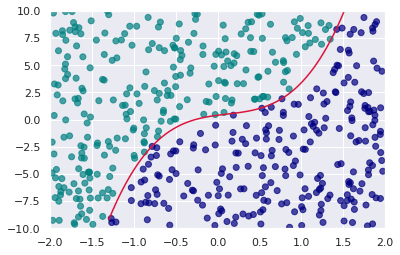

In [ ]:
np.random.seed(42)
x = np.random.uniform(-2, 2, size=500)
y = np.random.uniform(-10, 10, size=500)
x_lim = np.arange(-1.3, 1.8, 0.01)
y_lim = 3.*x_lim**3+1.*x_lim-1.*x_lim**2+0.4
X=[]
Y=[]
for i,j in zip(x,y):
  y_t = 3.*i**3+1.*i-1.*i**2+0.4
  X.append([i,j])
  if y_t>j:
    Y.append(1)
  else:
    Y.append(-1)
X=np.array(X)
Y=np.array(Y)
plt.plot(x_lim,y_lim, color = 'crimson')
plt.ylim(-10, 10)
plt.xlim(-2,2)
plt.scatter(X[:,0],X[:,1],c=Y,alpha=0.7,cmap = mycmap)

In [ ]:
# Create a SVC classifier using an RBF kernel
#clf = SVC(kernel='rbf', random_state=0, tol=0.001, gamma='auto', C=1000)
clf = SVC(kernel='rbf', random_state=0, tol=0.001, gamma=0.1, C=1e5)
# Train the classifier
clf.fit(X, Y)

SVC(C=100000.0, gamma=0.1, random_state=0)

Número de vetores de suporte:  16
Graus de liberdade:  500
Limite erro:  0.032


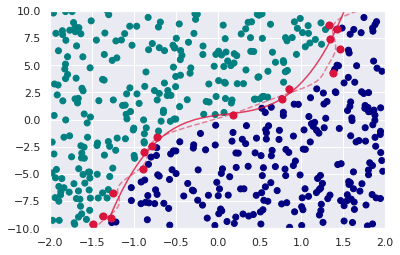

In [ ]:
# Plote os dados
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap = mycmap)
# Plote o contorno de decisão e os vetores de suporte em vermelho
plot_SVC(clf)

plt.plot(x_lim,y_lim,alpha = 0.8, color = 'crimson')
plt.ylim(-10, 10)
plt.xlim(-2,2)
print('Número de vetores de suporte: ', clf.support_.size)
print('Graus de liberdade: ', len(X))
print('Limite erro: ', clf.support_.size/len(X))

#### Parâmetros de ajuste

Escolher o kernel correto é crucial. O desempenho do modelo depende de uma *sábia* escolha da função de kernel. A dúvida sobre como decidir qual definição de kernel funcionará de forma eficiente para o seu conjunto de dados não é só sua.

A escolha de um kernel depende totalmente do tipo de conjunto de dados em que você está trabalhando. Se for linearmente separável, você deve optar pela função linear do kernel, pois é muito fácil de usar e a complexidade é muito menor em comparação com outras. Portanto, comece com uma hipótese de que seus dados sejam linearmente separáveis ​​e escolha uma função de kernel linear.

Você pode então trabalhar em direção às funções mais complexas do kernel. Normalmente, usamos SVM com RBF ou linear, porque outros kernels, como kernel polinomial, têm baixa eficiência e raramente são a melhor opção.

Para ajudar na escolha, existe uma biblioteca do `sklearn`



```
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = [
	{"kernel":
		["linear"],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]},
	{"kernel":
		["poly"],
		"degree": [2, 3, 4],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]},
	{"kernel":
		["rbf"],
		"gamma": ["auto", "scale"],
		"C": [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
]

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)


# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
```

Uma pesquisa usando  `GridSearchCV` testará exaustivamente todas as combinações possíveis desses hiperparâmetros, treinando um SVM para cada conjunto. A pesquisa em grade reportará então os melhores hiperparâmetros (ou seja, aqueles que maximizaram a precisão). Você pode inspecionar os melhores parâmetros encontrados pelo GridSearchCV no atributo `best_params_` e o melhor estimador no atributo `best_estimator_`

Uma vez que tenha a melhor combinação de hiperparâmetros, o `fit` constrói um único novo modelo.


Mas, isso é assunto da próxima aula...